# **LAMIA PROJETO FINAL**

# **Bibliotecas Necessárias**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# **Carregamento de dados e visualização**

This is an example of a normal lung without any cancer

In [ ]:
import os

from google.colab import files
print("Faça upload do arquivo kaggle.json:")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray_data

dataset_path = "chest_xray_data/chest_xray"
if os.path.exists(dataset_path):
    print("Dataset encontrado!")
    print(f"Pasta train: {len(os.listdir(os.path.join(dataset_path, 'train')))} subpastas")
    print(f"Pasta test: {len(os.listdir(os.path.join(dataset_path, 'test')))} subpastas")
    print(f"Pasta val: {len(os.listdir(os.path.join(dataset_path, 'val')))} subpastas")
else:
    print("Erro: Dataset não encontrado!")


Faça upload do arquivo kaggle.json:


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray_data/chest_xray/train/NORMAL/IM-0450-00

In [ ]:
cv2.imread("/content/chest_xray_data/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg").shape

(1128, 1664, 3)

In [ ]:
import os, cv2, numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def load_split(data_dir):
    X, y = [], []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        if not os.path.isdir(path):
            print(f"Pasta não encontrada: {path}")
            continue

        for fname in os.listdir(path):
            fpath = os.path.join(path, fname)
            try:
                img_arr = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Imagem inválida (None): {fpath}")
                    continue
                resized = cv2.resize(img_arr, (img_size, img_size))
                X.append(resized)
                y.append(class_num)
            except Exception as e:
                print(f"Erro em {fpath}: {e}")

    X = np.array(X, dtype=np.float32) / 255.0        # normaliza 0-1
    X = np.expand_dims(X, axis=-1)                   # (N, 150, 150, 1)
    y = np.array(y, dtype=np.int64)
    return X, y

train_dir = "/content/chest_xray_data/chest_xray/train"
val_dir   = "/content/chest_xray_data/chest_xray/val"
test_dir  = "/content/chest_xray_data/chest_xray/test"

X_train, y_train = load_split(train_dir)
X_val,   y_val   = load_split(val_dir)
X_test,  y_test  = load_split(test_dir)

print(X_train.shape, y_train.shape)
print(X_val.shape,   y_val.shape)
print(X_test.shape,  y_test.shape)


(5216, 150, 150, 1) (5216,)
(16, 150, 150, 1) (16,)
(624, 150, 150, 1) (624,)


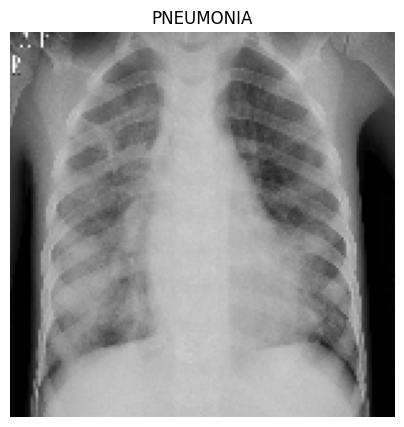

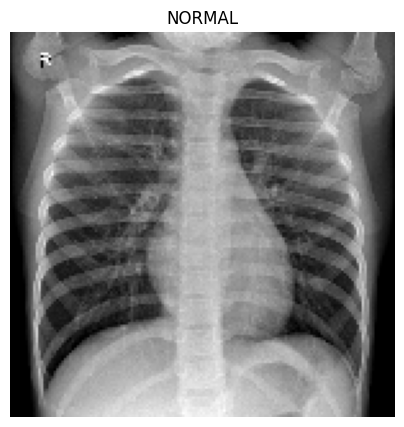

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.imshow(X_train[0].squeeze(), cmap='gray')  # (150,150)
plt.title(labels[int(y_train[0])])
plt.axis('off')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(X_train[-1].squeeze(), cmap='gray')
plt.title(labels[int(y_train[-1])])
plt.axis('off')
plt.show()


In [ ]:
x_train, y_train = X_train.astype(np.float32), y_train
x_val,   y_val   = X_val.astype(np.float32),   y_val
x_test,  y_test  = X_test.astype(np.float32),  y_test


In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
#ele cria iamgens com data augmentation aumentando a variabilidade do treino com isso diminuindo a chance de overffiting
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(x_train)


In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8037 - loss: 1.1159 - val_accuracy: 0.5000 - val_loss: 37.1587 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.8769 - loss: 0.3490 - val_accuracy: 0.5000 - val_loss: 40.2280 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9094 - loss: 0.2332
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9095 - loss: 0.2332 - val_accuracy: 0.5000 - val_loss: 22.8488 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.9393 - loss: 0.1639 - val_accuracy: 0.5625 - val_loss: 2.2347 - learning_rate: 3.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9481 - loss: 0.1284 - val_accuracy: 0.5000 - val_loss: 20.4419 - learning_rate: 3.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9547 - loss: 0.1362

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.85      0.89       390
   Normal (Class 1)       0.79      0.91      0.84       234

           accuracy                           0.87       624
          macro avg       0.86      0.88      0.87       624
       weighted avg       0.88      0.87      0.87       624



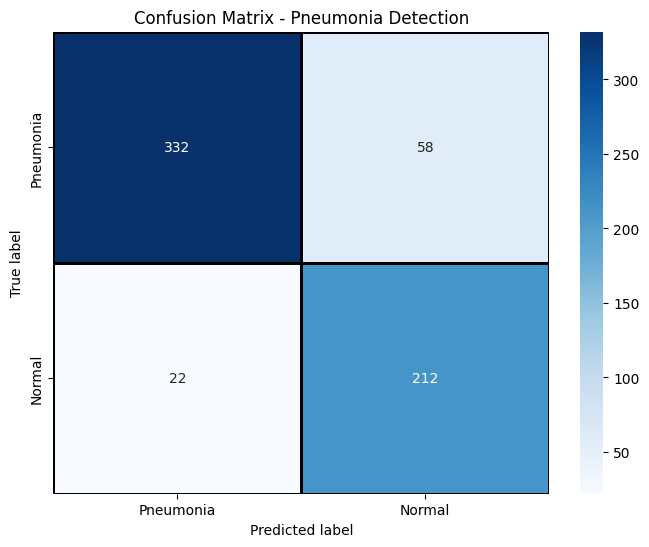

✅ Matriz de confusão salva em Resultado/confusion_matrix.png
📝 Relatório salvo em Resultado/classification_report.txt


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

THRESH = 0.5
tick_labels = ['Pneumonia', 'Normal']

os.makedirs("Resultado", exist_ok=True)

y_true = np.array(y_test)
if y_true.ndim == 2:
    if y_true.shape[1] == 1:
        y_true = y_true.ravel()
    else:
        y_true = y_true.argmax(axis=1)
y_true = y_true.astype(int)

y_pred_prob = model.predict(X_test, verbose=0).ravel()
predictions = (y_pred_prob >= THRESH).astype(int)

report = classification_report(
    y_true,
    predictions,
    target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']
)
print(report)

with open(os.path.join("Resultado", "classification_report.txt"), "w") as f:
    f.write(report)

cm = confusion_matrix(y_true, predictions, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=['0','1'], columns=['0','1'])

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_df,
    cmap="Blues",
    linecolor='black',
    linewidths=1,
    annot=True,
    fmt='d',
    xticklabels=tick_labels,
    yticklabels=tick_labels
)
plt.title("Confusion Matrix - Pneumonia Detection")
plt.xlabel("Predicted label")
plt.ylabel("True label")

out_path = os.path.join("Resultado", "confusion_matrix.png")
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Matriz de confusão salva em {out_path}")
print("Relatório salvo em Resultado/classification_report.txt")


#Testes com imagem fora


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OK! Pasta localizada: /content/drive/MyDrive/Colab Notebooks/Imagens
Arquivos na pasta: 10

== Avaliação com threshold = 0.25 ==
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         5
   PNEUMONIA       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix [rows=true, cols=pred]:
 [[5 0]
 [0 5]]


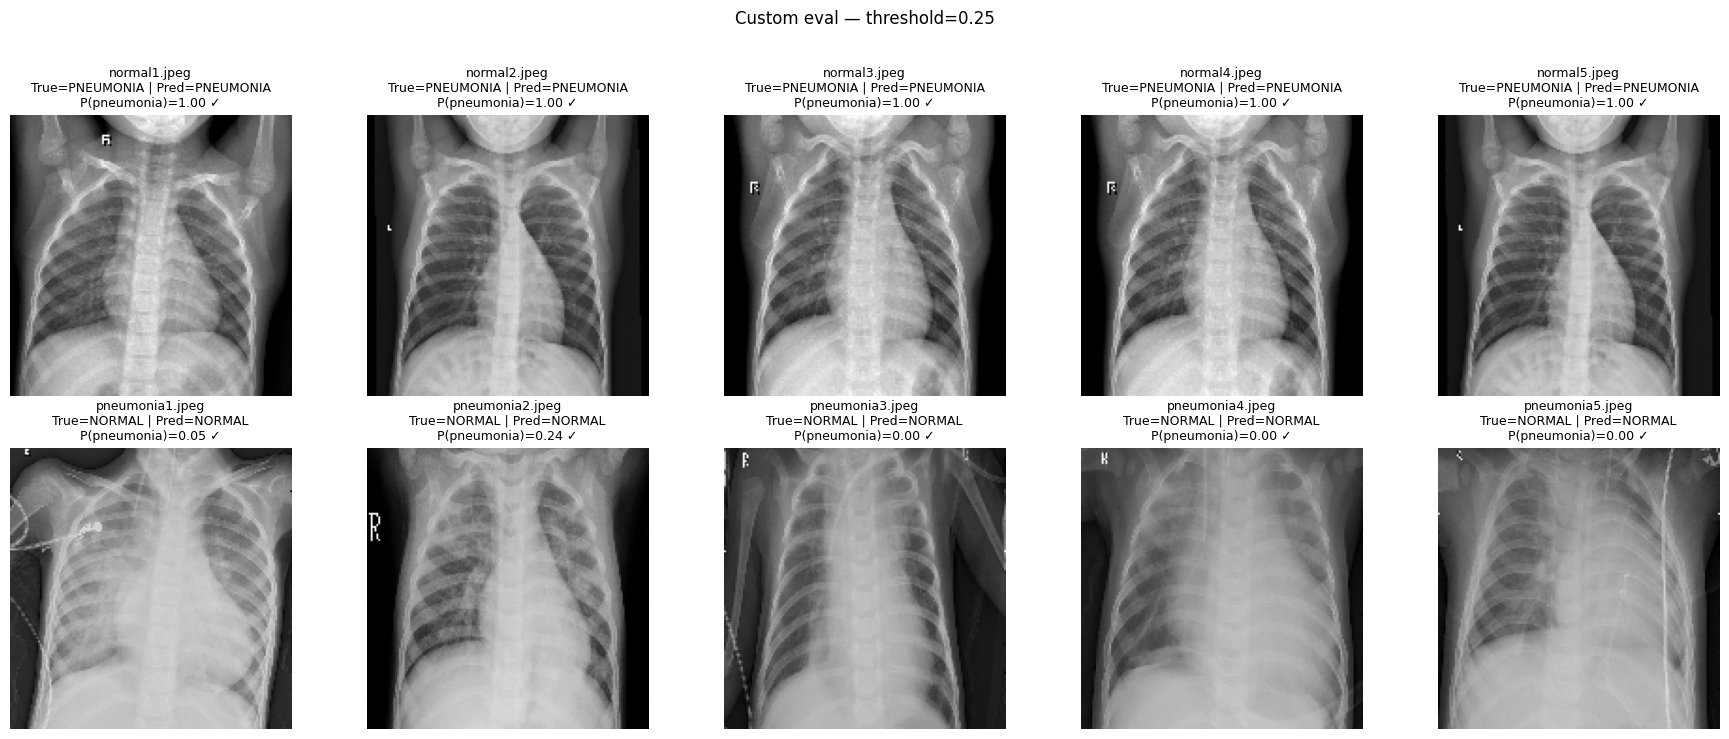

[OK] PNG salvo em: /content/drive/MyDrive/Efficientnet0/custom_eval/grid_custom_t0.25_20250916-163759.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

from pathlib import Path
root = Path('/content/drive/MyDrive')
assert root.exists(), "Seu Drive não está acessível em /content/drive/MyDrive"

cands = [p for p in root.iterdir() if p.is_dir() and p.name.lower() == 'imagens']
if not cands:
    cands = [p for p in root.rglob('*') if p.is_dir() and p.name.lower() == 'imagens']

if not cands:
    print("Pastas no Meu Drive:", [p.name for p in root.iterdir() if p.is_dir()])
    raise FileNotFoundError('Não encontrei nenhuma pasta chamada "Imagens" no seu Drive.\n'
                            'Mova/copie a pasta para o Meu Drive ou ajuste o código para o caminho correto.')

IMG_DIR = str(cands[0])
print("OK! Pasta localizada:", IMG_DIR)

num_files = len([f for f in Path(IMG_DIR).iterdir() if f.is_file()])
print("Arquivos na pasta:", num_files)

import os, datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

TH = 0.25

if 'y_prob' not in globals():
    raise RuntimeError("y_prob não encontrado. Rode primeiro o bloco de avaliação/robusto que calcula y_prob.")

y_pred = (y_prob >= TH).astype(int)

print(f"\n== Avaliação com threshold = {TH:.2f} ==")
print(classification_report(y_true, y_pred, target_names=["NORMAL","PNEUMONIA"], digits=2))
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix [rows=true, cols=pred]:\n", cm)

OUT_DIR = "/content/drive/MyDrive/Efficientnet0/custom_eval"
os.makedirs(OUT_DIR, exist_ok=True)
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cols = 5
rows = int(np.ceil(len(files)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.6*cols, 3.6*rows))
axes = np.atleast_2d(axes)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= len(files): continue
    img = tf.keras.utils.load_img(str(files[i]), target_size=target_size, color_mode=("grayscale" if C==1 else "rgb"))
    ax.imshow(img, cmap=("gray" if C==1 else None))
    ok = "✓" if y_true[i] == y_pred[i] else "✗"
    ax.set_title(
        f"{files[i].name}\nTrue={['NORMAL','PNEUMONIA'][y_true[i]]} | "
        f"Pred={['NORMAL','PNEUMONIA'][y_pred[i]]}\nP(pneumonia)={y_prob[i]:.2f} {ok}",
        fontsize=9
    )

plt.suptitle(f"Custom eval — threshold={TH:.2f}", y=1.02, fontsize=12)
plt.tight_layout()
png_path = os.path.join(OUT_DIR, f"grid_custom_t{TH:.2f}_{ts}.png")
fig.savefig(png_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"[OK] PNG salvo em: {png_path}")
